## Load Dataset

In [1]:
import os


path_anno = '/home/anthony/Documents/Homework Documents/Inno Lab 5/WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt'
path_images = '/home/anthony/Documents/Homework Documents/Inno Lab 5/WFLW_images'

### read annotations

In [2]:
# read annotations
n_landmarks = 196


def read_anno(path, images_dir=path_images):
    with open(path) as f:
        raw_lines = f.readlines()
    return list(map(lambda x: _read_line(x, images_dir), raw_lines))

def _read_line(line, images_dir):
    words = [x.strip() for x in line.split(' ')]
    landmarks = list(map(float, words[:n_landmarks]))
    landmarks = [(landmarks[2 * i], landmarks[2 * i + 1]) for i in range(n_landmarks // 2)]

    rectangle = list(map(int, words[n_landmarks: n_landmarks + 4]))

    image_path = os.path.join(path_images, words[-1])

    return image_path, rectangle, landmarks


In [3]:
annotations = read_anno(path_anno)
print(f'There are {len(annotations)} annotations in the training set.\n')
print(annotations[0])

There are 7500 annotations in the training set.

('/home/anthony/Documents/Homework Documents/Inno Lab 5/WFLW_images/51--Dresses/51_Dresses_wearingdress_51_377.jpg', [306, 308, 696, 870], [(309.307007, 538.369019), (317.857345, 560.120847), (322.271739, 583.014395), (319.583872, 606.149851), (314.765287, 629.015727), (313.308619, 652.33149), (315.648163, 675.558182), (322.526266, 697.876907), (331.880068, 719.301121), (342.087363, 740.336765), (352.822689, 761.107391), (363.917162, 781.689357), (374.35333, 802.607217), (383.434488, 824.152584), (393.923435, 845.012933), (410.131531, 861.653107), (431.559411, 870.597153), (463.665456, 870.444454), (494.908844, 862.408332), (525.060623, 850.878448), (554.767143, 838.22663), (583.901545, 824.323471), (611.315726, 807.31818), (635.222521, 785.701484), (654.409992, 759.788921), (668.785995, 730.918097), (678.714659, 700.216404), (685.604212, 668.677501), (691.110277, 636.861987), (696.002773, 604.946485), (699.955999, 572.901835), (702.9662

### visulize landmarks

In [4]:
# visulize landmarks
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle


def draw_anno(anno):
    'draw the image and landmarks for an annotation'
    path, rectangle, landmarks = anno

    # read image
    image = Image.open(path)

    # build rect
    x, y, x2, y2 = rectangle
    rect = Rectangle((x, y), x2 - x, y2 - y, fill=False, color='tab:green')

    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.add_patch(rect)
    ax.scatter(*zip(*landmarks), s=1, c='r')


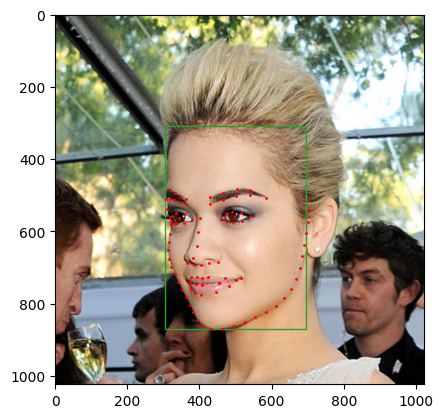

In [5]:
draw_anno(annotations[0])

### Image Cropping & Normalization

In [6]:
import torch
from torchvision import transforms


tensor2image = transforms.ToPILImage()
image2tensor = transforms.PILToTensor()


def preprocess(anno, resize=None):
    "preprocessing for an annotation"
    image = crop_image(anno, resize)
    inputs = image2tensor(image) / 255

    landmarks = torch.Tensor(normalize(anno))

    return inputs, landmarks


def draw_data(data, ax=None):
    "draw a record of data"
    inputs, landmarks = data
    image = tensor2image(inputs)
    shape = torch.Tensor(list(inputs.shape[-1:-3:-1]))

    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(image)
    ax.scatter(*((landmarks + 0.5) * shape).T, s=1, c='g', label='true')
    return ax


def crop_image(anno, resize=None):
    path, (x0, y0, x1, y1), _ = anno
    image = Image.open(path)
    image = image.crop((x0, y0, x1, y1))

    if resize:
        image = image.resize(resize)

    return image


def normalize(anno):
    _, (x0, y0, x1, y1), landmarks = anno

    # width and height
    w, h = x1 - x0, y1 - y0
    normalized = [((x - x0) / w - 0.5, (y - y0) / h - 0.5) for x, y in landmarks]
    return normalized


/home/anthony/anaconda3/envs/ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([3, 128, 128]) torch.Size([98, 2])


<Axes: >

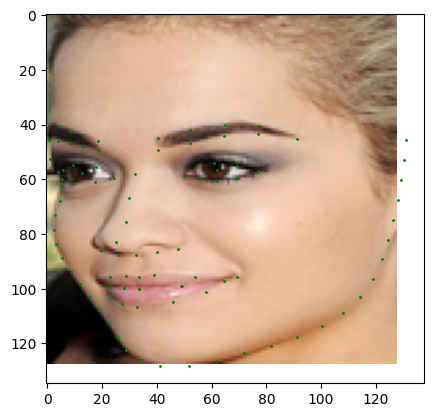

In [7]:
data = preprocess(annotations[0], (128, 128))
print(data[0].shape, data[1].shape)
draw_data(data)

## Build Train & Test Data Loaders

In [8]:
from torch.utils.data import Dataset, DataLoader

### build dataset

In [9]:
# define the dataset
class LandmarksDataSet(Dataset):

    def __init__(self, annotations, images_dir, resize=None, transform=None):
        if isinstance(annotations, str):            
            self.annotations = read_anno(annotations, images_dir)
        else:
            self.annotations = annotations
        self.resize = resize
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, ind):
        image, label = preprocess(self.annotations[ind], self.resize)
        output = {"image": image, "labels": label}

        if self.transform:
            output = self.transform(output)

        return output['image'], output['labels']


### separate training and test set

In [10]:
from random import shuffle


# separate training and test data
shuffle(annotations)
test_length = int(len(annotations) * 0.8)
train_data = annotations[:test_length]
test_data = annotations[test_length:]

print(len(train_data), len(test_data))

6000 1500


In [11]:
# training set
training_set = LandmarksDataSet(train_data, path_images, (128, 128))
feature, label = training_set[0]
print(feature.shape, label.shape)

torch.Size([3, 128, 128]) torch.Size([98, 2])


In [12]:
# test set
test_set = LandmarksDataSet(test_data, path_images, (128, 128))

### build data loader

In [13]:
batch_size = 60

training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
features, labels = next(iter(training_loader))
print(features.shape, labels.shape)

torch.Size([60, 3, 128, 128]) torch.Size([60, 98, 2])


## CNN Model

### Build Model, Optimizer, and Loss

In [14]:
import torch.nn as nn
import torch.nn.functional as F


# build model
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.pooling = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.conv3 = nn.Conv2d(20, 40, 3)
        self.conv4 = nn.Conv2d(40, 60, 3)
        self.conv5 = nn.Conv2d(60, 80, 3)
        self.fc1 = nn.Linear(4 * 4 * 80, 700)
        self.fc2 = nn.Linear(700, 700)
        self.fc3 = nn.Linear(700, 98 * 2)

    def forward(self, x):
        # input = 128
        x = F.relu(self.conv1(x))  # 124
        x = self.pooling(x)  # 62
        x = F.relu(self.conv2(x))  # 60
        x = self.pooling(x)  # 30
        x = F.relu(self.conv3(x))  # 28
        x = self.pooling(x)  # 14
        x = F.relu(self.conv4(x))  # 12
        x = self.pooling(x)  # 6
        x = F.relu(self.conv5(x))  # 4

        # full connect
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.reshape(-1, 98, 2)
        return x


In [15]:
model = CNN()
model(features).shape

torch.Size([60, 98, 2])

In [16]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

Layer: conv1.weight | Size: torch.Size([10, 3, 5, 5])
Layer: conv1.bias | Size: torch.Size([10])
Layer: conv2.weight | Size: torch.Size([20, 10, 3, 3])
Layer: conv2.bias | Size: torch.Size([20])
Layer: conv3.weight | Size: torch.Size([40, 20, 3, 3])
Layer: conv3.bias | Size: torch.Size([40])
Layer: conv4.weight | Size: torch.Size([60, 40, 3, 3])
Layer: conv4.bias | Size: torch.Size([60])
Layer: conv5.weight | Size: torch.Size([80, 60, 3, 3])
Layer: conv5.bias | Size: torch.Size([80])
Layer: fc1.weight | Size: torch.Size([700, 1280])
Layer: fc1.bias | Size: torch.Size([700])
Layer: fc2.weight | Size: torch.Size([700, 700])
Layer: fc2.bias | Size: torch.Size([700])
Layer: fc3.weight | Size: torch.Size([196, 700])
Layer: fc3.bias | Size: torch.Size([196])


In [17]:
# define optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
# define loss function
def euclidean_distance(x, y):
    "euclidean distance"
    return ((x - y)**2).sum()**0.5

### Model Training

In [19]:
import numpy as np


def train_model(epoches=5):
    torch.cuda.empty_cache()
    epoch_losses = []
    best_loss = torch.inf
    best_param = model.state_dict()
    for epoch in range(1, epoches + 1):
        print(f'-----training epoch {epoch}-----')
        train_loop(training_loader, model, euclidean_distance, optimizer)
        loss = test_loop(test_loader, model, euclidean_distance)
        if loss <= best_loss:
            best_loss = loss
            best_param = model.state_dict()
        epoch_losses.append((epoch, loss))
    print('-----done!!!-----')
    return epoch_losses, best_param


def evaluate(epoch_losses):
    plt.plot(*zip(*epoch_losses))
    plt.title('test loss of each epoch')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    print(f'The best test loss is {min([y for _, y in epoch_losses]):>7f}')
    print(f'The final test loss is {epoch_losses[-1][1]:>7f}')


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    cuda = torch.cuda.device_count()
    if cuda:
        model = model.cuda()

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        if cuda:
            X = X.cuda()
            y = y.cuda()

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)

    cuda = torch.cuda.device_count()
    if cuda:
        model = model.cuda()

    model.eval()
    losses = []
    for X, y in dataloader:
        if cuda:
            X = X.cuda()
            y = y.cuda()

        pred = model(X)
        loss = loss_fn(pred, y).cpu().detach().numpy()
        losses.append(loss)

    test_loss = np.mean(losses)
    print(f'test loss: {test_loss:>7f}')
    return test_loss
    

In [20]:
epoch_losses, best_param = train_model(10)
model.load_state_dict(best_param)

-----training epoch 1-----
train loss: 29.558559  [   60/ 6000]
train loss: 11.387153  [  660/ 6000]
train loss: 11.403909  [ 1260/ 6000]
train loss: 10.719672  [ 1860/ 6000]
train loss: 11.108076  [ 2460/ 6000]
train loss: 10.736418  [ 3060/ 6000]
train loss: 11.134360  [ 3660/ 6000]
train loss: 12.216928  [ 4260/ 6000]
train loss: 10.246905  [ 4860/ 6000]
train loss: 10.270837  [ 5460/ 6000]
test loss: 11.032305
-----training epoch 2-----
train loss: 11.549990  [   60/ 6000]
train loss: 11.750794  [  660/ 6000]
train loss: 10.443821  [ 1260/ 6000]
train loss: 10.757866  [ 1860/ 6000]
train loss: 9.673550  [ 2460/ 6000]
train loss: 10.301020  [ 3060/ 6000]
train loss: 10.563667  [ 3660/ 6000]
train loss: 11.548737  [ 4260/ 6000]
train loss: 11.015730  [ 4860/ 6000]
train loss: 11.154043  [ 5460/ 6000]
test loss: 11.038025
-----training epoch 3-----
train loss: 10.157995  [   60/ 6000]
train loss: 12.400494  [  660/ 6000]
train loss: 11.514024  [ 1260/ 6000]
train loss: 10.913588  [ 18

<All keys matched successfully>

In [21]:
# save the model
path_models = '/home/anthony/Documents/Homework Documents/Inno Lab 5/models'
os.makedirs(path_models, exist_ok=True)
torch.save(model.state_dict(), os.path.join(path_models, 'cnn.pth'))

### Evaluation

#### Final Loss

The best test loss is 4.848000
The final test loss is 4.848000


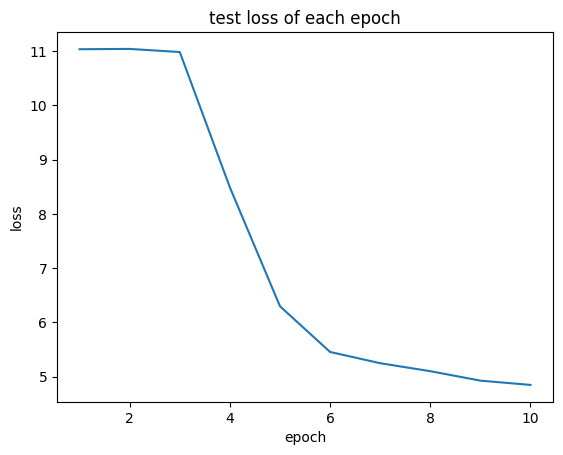

In [22]:
evaluate(epoch_losses)

#### Visualization of Label and Prediction

In [23]:
from collections.abc import Iterable


def draw_pred(X, y, indices=range(5)):
    if isinstance(indices, Iterable):
        indices = list(indices)
        fig, axes = plt.subplots(1, len(indices))
        fig.set_size_inches(12, 2)
    else:
        indices = [indices]
        fig, axes = plt.subplots(1, 1)
        axes = [axes]

    pred = (model(X).detach().numpy() + 0.5) * list(X.shape[-2:])
    for index, ax in zip(indices, axes):
        p = pred[index]
        ax = draw_data((X[index], y[index]), ax=ax)
        ax.scatter(*p.T, s=1, c='r', label='pred')
    fig.legend(*ax.get_legend_handles_labels())


In [24]:
def show_prediction(model, test_loader, index=range(6)):
    model.cpu()
    X, y = next(iter(test_loader))
    draw_pred(X, y, index)


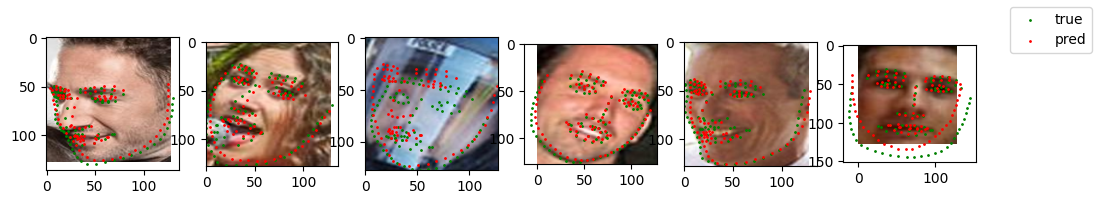

In [25]:
show_prediction(model, test_loader)

### Data Augmentation

In [51]:
from random import random
from torchvision.transforms import v2


class RandomFlip:
    """
    Flip the image randomly

    params
    ------
    p : float in [0, 1],
        the probability of flipping.
    direction : "both", "horizontal", or "vertical",
        the flipping direction

    """
    __horizontal_flip = v2.RandomHorizontalFlip(p=1)
    __vertical_flip = v2.RandomVerticalFlip(p=1)
    __horizontal_scalar = torch.Tensor([-1, 1])
    __vertical_scalar = torch.Tensor([1, -1])


    def __init__(self, p, direction='both'):
        self.p = p

        if isinstance(direction, list):
            self.direction = direction
        elif direction == 'both':
            self.direction = ["horizontal", "vertical"]
        else:
            self.direction = [direction]
        assert all(map(lambda x: x in {"horizontal", "vertical"}, self.direction))
    
    def __call__(self, sample):
        for direction in self.direction:
            if random() <= self.p:
                sample = self.__flip(sample, direction)
        return sample

    def __flip(self, sample, direction):
        image = sample['image']  # tensor form
        labels = sample['labels']  # normalized coord

        if direction == "horizontal":
            flipper = self.__horizontal_flip
            scalar = self.__horizontal_scalar
        else:  # vertical
            flipper = self.__vertical_flip
            scalar = self.__vertical_scalar

        # flip the image
        sample['image'] = flipper(image)

        # flip the labels
        sample['labels'] = labels * scalar

        return sample


augment = v2.Compose([
    RandomFlip(0.5, "horizontal"),
    # v2.ColorJitter(brightness=.5, hue=.3),
    v2.RandomPhotometricDistort(p=0.3),
])

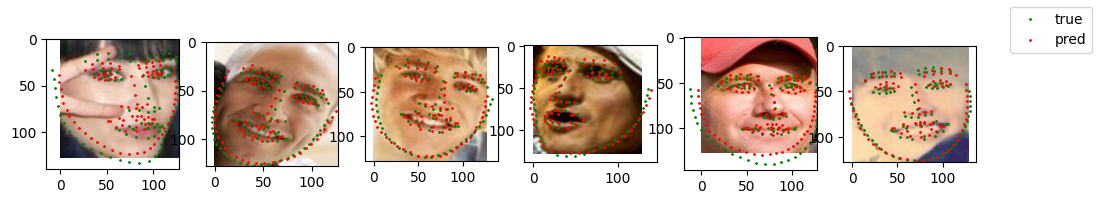

In [42]:
training_set = LandmarksDataSet(train_data, path_images, (128, 128), transform=augment)
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_set = LandmarksDataSet(test_data, path_images, (128, 128), transform=augment)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


model = CNN()
model.load_state_dict(torch.load(os.path.join(path_models, 'cnn.pth')))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


X, y = next(iter(training_loader))
draw_pred(X, y, range(6))

In [43]:
epoch_losses, best_param = train_model(10)
model.load_state_dict(best_param)

-----training epoch 1-----
train loss: 31.219391  [   60/ 6000]
train loss: 21.160248  [  660/ 6000]
train loss: 21.399025  [ 1260/ 6000]
train loss: 21.256907  [ 1860/ 6000]
train loss: 21.456804  [ 2460/ 6000]
train loss: 21.019541  [ 3060/ 6000]
train loss: 21.319517  [ 3660/ 6000]
train loss: 22.031733  [ 4260/ 6000]
train loss: 21.123865  [ 4860/ 6000]
train loss: 21.086258  [ 5460/ 6000]
test loss: 21.341181
-----training epoch 2-----
train loss: 21.112455  [   60/ 6000]
train loss: 20.696470  [  660/ 6000]
train loss: 21.683901  [ 1260/ 6000]
train loss: 20.498077  [ 1860/ 6000]
train loss: 21.294935  [ 2460/ 6000]
train loss: 20.501369  [ 3060/ 6000]
train loss: 21.225061  [ 3660/ 6000]
train loss: 21.138796  [ 4260/ 6000]
train loss: 21.277681  [ 4860/ 6000]
train loss: 21.113256  [ 5460/ 6000]
test loss: 21.207102
-----training epoch 3-----
train loss: 21.265411  [   60/ 6000]
train loss: 21.110464  [  660/ 6000]
train loss: 21.326426  [ 1260/ 6000]
train loss: 20.823046  [ 1

<All keys matched successfully>

The best test loss is 21.587811
The final test loss is 21.627598


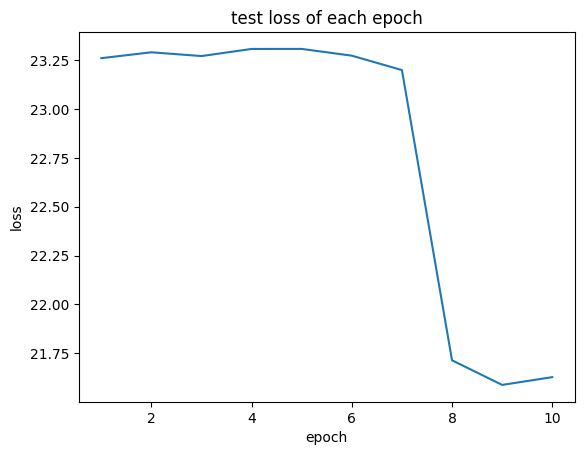

In [40]:
evaluate(epoch_losses)

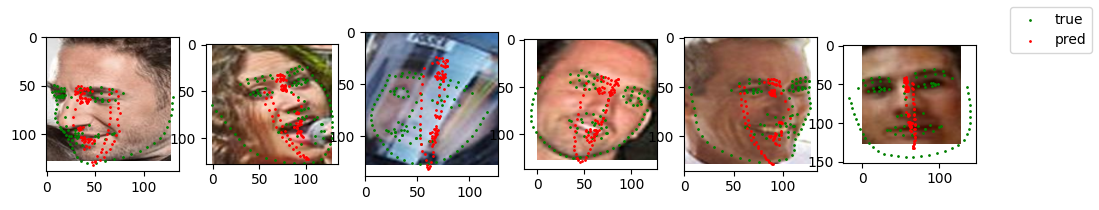

In [41]:
show_prediction(model, test_loader)

This simple CNN can not handle the flipped images.

## Transfer Learning

### Custom MobileNet V2

In [44]:
import torchvision


torchvision.models.mobilenet_v2(pretrained=True, progress=False)

/home/anthony/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anthony/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [45]:
class CustomMobilenetV2(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.mobilenet_v2(pretrained=True, progress=False)

        # lock the parameters
        for param in self.model.parameters():
            pass
            # param.requires_grad = False

        # only train the last layer
        for param in self.model.classifier:
            pass
            # param.requires_grad = True

        n_features = self.model.classifier[-1].out_features
        self.fc1 = nn.Linear(n_features, n_features)
        self.fc2 = nn.Linear(n_features, 98 * 2)

    def forward(self, x):
        x = F.relu(self.model(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.reshape(-1, 98, 2)


In [46]:
model = CustomMobilenetV2()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# change the input shape
training_set = LandmarksDataSet(train_data, path_images, (224, 224), transform=None)
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_set = LandmarksDataSet(test_data, path_images, (224, 224))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [47]:
epoch_losses, best_param = train_model(10)
model.load_state_dict(best_param)

-----training epoch 1-----
train loss: 53.518944  [   60/ 6000]
train loss: 12.416390  [  660/ 6000]
train loss: 9.854677  [ 1260/ 6000]
train loss: 10.130084  [ 1860/ 6000]
train loss: 7.868461  [ 2460/ 6000]
train loss: 7.914977  [ 3060/ 6000]
train loss: 7.834928  [ 3660/ 6000]
train loss: 7.043373  [ 4260/ 6000]
train loss: 7.050790  [ 4860/ 6000]
train loss: 5.894962  [ 5460/ 6000]
test loss: 5.453286
-----training epoch 2-----
train loss: 5.740980  [   60/ 6000]
train loss: 6.088267  [  660/ 6000]
train loss: 6.008359  [ 1260/ 6000]
train loss: 4.785007  [ 1860/ 6000]
train loss: 4.782727  [ 2460/ 6000]
train loss: 5.554906  [ 3060/ 6000]
train loss: 5.019927  [ 3660/ 6000]
train loss: 5.774812  [ 4260/ 6000]
train loss: 5.446324  [ 4860/ 6000]
train loss: 4.968289  [ 5460/ 6000]
test loss: 5.747377
-----training epoch 3-----
train loss: 6.126702  [   60/ 6000]
train loss: 8.948503  [  660/ 6000]
train loss: 5.792681  [ 1260/ 6000]
train loss: 4.233437  [ 1860/ 6000]
train loss: 

<All keys matched successfully>

The best test loss is 3.790309
The final test loss is 3.790309


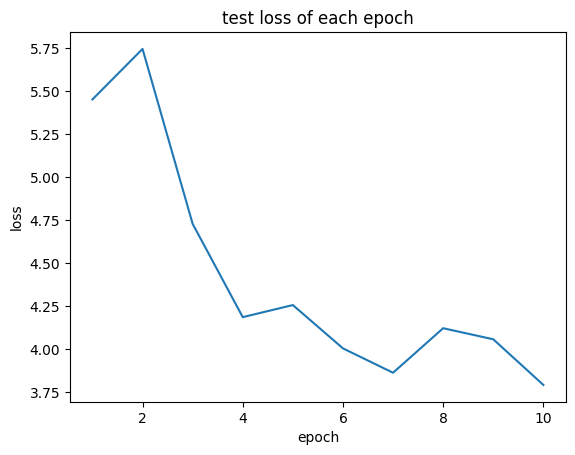

In [48]:
evaluate(epoch_losses)

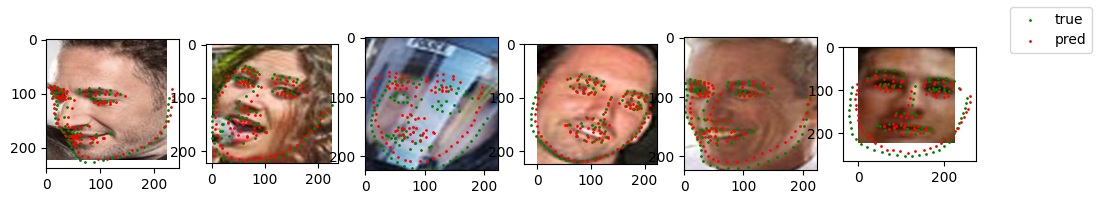

In [49]:
show_prediction(model, test_loader)

In [50]:
# save the model
path_models = '/home/anthony/Documents/Homework Documents/Inno Lab 5/models'
os.makedirs(path_models, exist_ok=True)
torch.save(model.state_dict(), os.path.join(path_models, 'custom_mobilenet_v2.pth'))

#### Data Augmentation

In [52]:
training_set = LandmarksDataSet(train_data, path_images, (224, 224), transform=augment)
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_set = LandmarksDataSet(test_data, path_images, (224, 224), transform=augment)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [53]:
epoch_losses, best_param = train_model(10)
model.load_state_dict(best_param)

-----training epoch 1-----
train loss: 27.571753  [   60/ 6000]
train loss: 23.134577  [  660/ 6000]
train loss: 21.843538  [ 1260/ 6000]
train loss: 21.474556  [ 1860/ 6000]
train loss: 20.824955  [ 2460/ 6000]
train loss: 20.998184  [ 3060/ 6000]
train loss: 21.169235  [ 3660/ 6000]
train loss: 20.691532  [ 4260/ 6000]
train loss: 20.935623  [ 4860/ 6000]
train loss: 20.962915  [ 5460/ 6000]
test loss: 21.171797
-----training epoch 2-----
train loss: 21.239477  [   60/ 6000]
train loss: 20.708900  [  660/ 6000]
train loss: 21.812807  [ 1260/ 6000]
train loss: 21.800104  [ 1860/ 6000]
train loss: 21.018414  [ 2460/ 6000]
train loss: 21.165056  [ 3060/ 6000]
train loss: 21.091978  [ 3660/ 6000]
train loss: 21.153889  [ 4260/ 6000]
train loss: 20.667137  [ 4860/ 6000]
train loss: 21.169872  [ 5460/ 6000]
test loss: 21.153790
-----training epoch 3-----
train loss: 21.667093  [   60/ 6000]
train loss: 20.266294  [  660/ 6000]
train loss: 21.493233  [ 1260/ 6000]
train loss: 20.128597  [ 1

<All keys matched successfully>

The best test loss is 21.039566
The final test loss is 21.060349


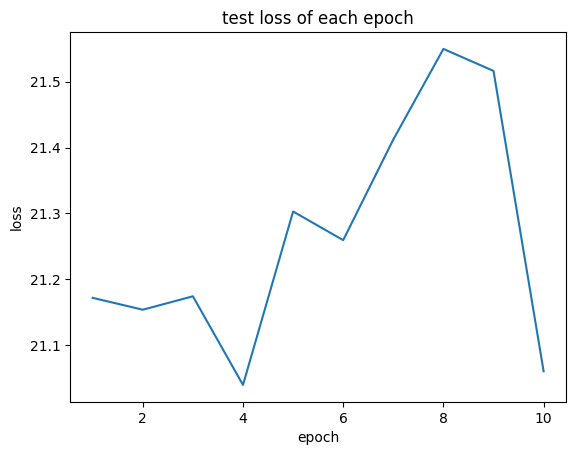

In [54]:
evaluate(epoch_losses)

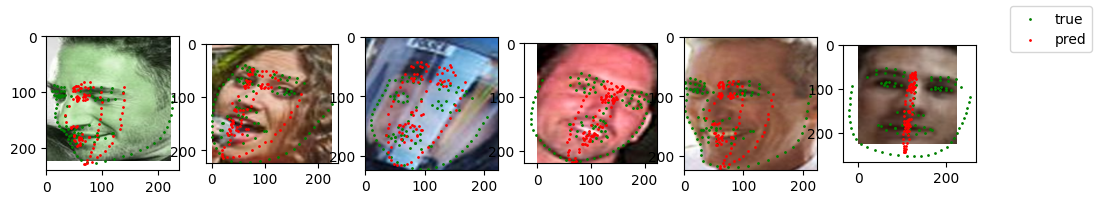

In [55]:
show_prediction(model, test_loader)

### Custom ResNet18

In [56]:
torchvision.models.resnet18(pretrained=True, progress=False)

/home/anthony/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
import torchvision


class CustomResNet18(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.mobilenet_v2(pretrained=True, progress=False)

        # lock the parameters
        for param in self.model.parameters():
            pass
            # param.requires_grad = False

        # only train the last layer
        for param in self.model.classifier:
            pass
            # param.requires_grad = True

        n_features = self.model.classifier[-1].out_features
        self.fc1 = nn.Linear(n_features, 98 * 2)

    def forward(self, x):
        x = F.relu(self.model(x))
        x = self.fc1(x)
        return x.reshape(-1, 98, 2)


In [58]:
model = CustomResNet18()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# change the input shape
batch_size = 30
training_set = LandmarksDataSet(train_data, path_images, (256, 256), transform=None)
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_set = LandmarksDataSet(test_data, path_images, (256, 256))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [59]:
epoch_losses, best_param = train_model(10)
model.load_state_dict(best_param)

-----training epoch 1-----
train loss: 67.166176  [   30/ 6000]
train loss: 13.677987  [  330/ 6000]
train loss: 8.422450  [  630/ 6000]
train loss: 8.917576  [  930/ 6000]
train loss: 8.527295  [ 1230/ 6000]
train loss: 7.995371  [ 1530/ 6000]
train loss: 8.109171  [ 1830/ 6000]
train loss: 6.188379  [ 2130/ 6000]
train loss: 6.165043  [ 2430/ 6000]
train loss: 5.361052  [ 2730/ 6000]
train loss: 5.593863  [ 3030/ 6000]
train loss: 4.950535  [ 3330/ 6000]
train loss: 5.402389  [ 3630/ 6000]
train loss: 5.100405  [ 3930/ 6000]
train loss: 5.698383  [ 4230/ 6000]
train loss: 4.614476  [ 4530/ 6000]
train loss: 4.330269  [ 4830/ 6000]
train loss: 5.265344  [ 5130/ 6000]
train loss: 4.336191  [ 5430/ 6000]
train loss: 4.737382  [ 5730/ 6000]
test loss: 4.071177
-----training epoch 2-----
train loss: 4.438545  [   30/ 6000]
train loss: 4.818763  [  330/ 6000]
train loss: 4.260933  [  630/ 6000]
train loss: 5.111731  [  930/ 6000]
train loss: 4.553771  [ 1230/ 6000]
train loss: 4.845729  [ 

<All keys matched successfully>

The best test loss is 2.645046
The final test loss is 2.645046


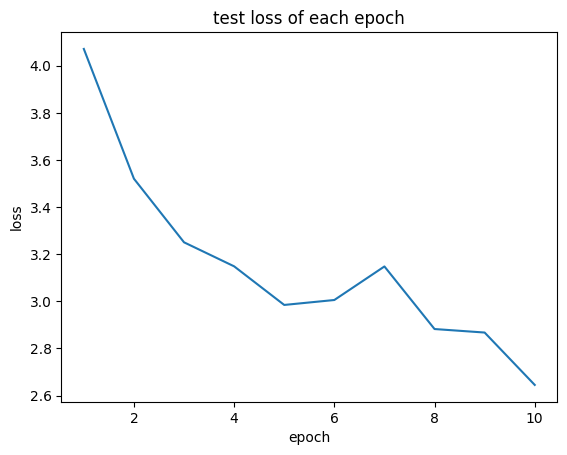

In [60]:
evaluate(epoch_losses)

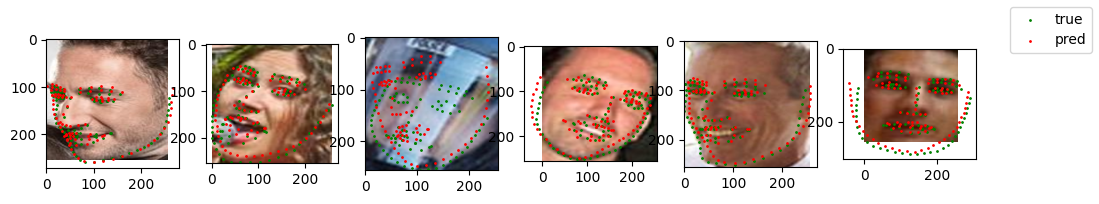

In [61]:
show_prediction(model, test_loader, range(6))

In [62]:
torch.save(model.state_dict(), os.path.join(path_models, 'custom_resnet_18.pth'))

#### Data Augmentation

In [66]:
model = CustomResNet18()
model.load_state_dict(torch.load(os.path.join(path_models, 'custom_resnet_18.pth')))


training_set = LandmarksDataSet(train_data, path_images, (256, 256), transform=augment)
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_set = LandmarksDataSet(test_data, path_images, (256, 256), transform=augment)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

/home/anthony/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anthony/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [67]:
epoch_losses, best_param = train_model(10)
model.load_state_dict(best_param)

-----training epoch 1-----
train loss: 17.367022  [   30/ 6000]
train loss: 18.243507  [  330/ 6000]
train loss: 24.064489  [  630/ 6000]
train loss: 23.306816  [  930/ 6000]
train loss: 23.618383  [ 1230/ 6000]
train loss: 21.300062  [ 1530/ 6000]
train loss: 18.883938  [ 1830/ 6000]
train loss: 20.524090  [ 2130/ 6000]
train loss: 17.201097  [ 2430/ 6000]
train loss: 20.974052  [ 2730/ 6000]
train loss: 19.246725  [ 3030/ 6000]
train loss: 17.069557  [ 3330/ 6000]
train loss: 20.519770  [ 3630/ 6000]
train loss: 21.680906  [ 3930/ 6000]
train loss: 20.497599  [ 4230/ 6000]
train loss: 20.282318  [ 4530/ 6000]
train loss: 21.255241  [ 4830/ 6000]
train loss: 25.013597  [ 5130/ 6000]
train loss: 22.610544  [ 5430/ 6000]
train loss: 20.824221  [ 5730/ 6000]
test loss: 20.735096
-----training epoch 2-----
train loss: 20.958466  [   30/ 6000]
train loss: 22.415997  [  330/ 6000]
train loss: 20.612423  [  630/ 6000]
train loss: 13.168118  [  930/ 6000]
train loss: 18.648716  [ 1230/ 6000]


<All keys matched successfully>

The best test loss is 20.616074
The final test loss is 20.616074


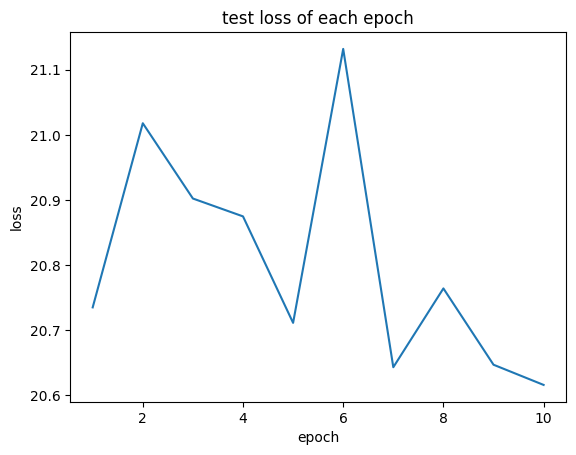

In [68]:
evaluate(epoch_losses)

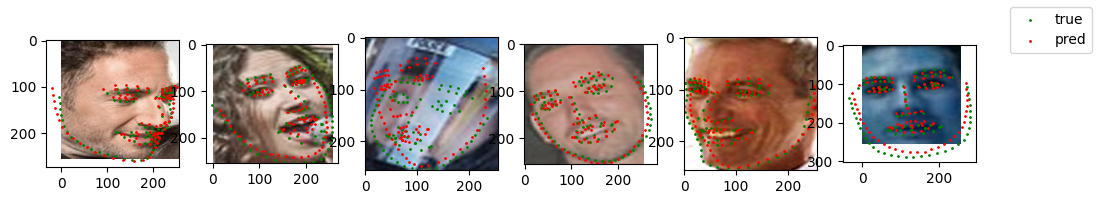

In [70]:
show_prediction(model, test_loader, range(6))

## Conclusion

### Test on the original test set

In [71]:
test_set = LandmarksDataSet(test_data, path_images, (256, 256), transform=None)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
final_loss = test_loop(dataloader=test_loader, model=model, loss_fn=euclidean_distance)

test loss: 2.587960


Even a simple CNN can work well with the original dataset (test loss = 4.848000). It performed worse after data augmentation.

In constrat, larger models (MobileNet_v2 and ResNet18) achieved lower losses (respectively 3.790309 and 2.645046). The biggest model ResNet18 shows robustness in the augmented data set. Its predictions looks appoximately correct and the loss on the original dataset decreased to 2.587960. 